# Setup

In [1]:
from data import load_data
from utils import MANUAL_SORT_COLS
from utils import FILTER_VALS

import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
import plotly.express as px

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from pymc import HalfCauchy, Model, Normal, sample

print(f"Running on PyMC v{pm.__version__}")

RANDOM_SEED = 1234
rng = np.random.default_rng(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.3.0


In [3]:
TARGET_COLUMNS = ['salary', 'bonus']
TIME_COLUMNS = ['timestamp']

sns.set_theme(style="whitegrid")
set_config(transform_output = "pandas")

In [4]:
def feature_extraction(df, selected_cols=None, dropna=False):

    df = df.copy()  # avoid unexpected side-effects

    # Use a boolean variable to model whether the title has "senior" in it
    df = (
        df
        .assign(
            is_senior=lambda df: df.job_title.str.contains("Senior").astype(float),
            is_hovedstaden=lambda df: (df.region=="Hovedtaden").astype(float),
            job_title_no_senior=lambda df: df.job_title.str.replace("Senior ", ""),
            has_subordinates=lambda df: (~df.num_subordinates.isin([pd.NA, "0"])).astype(float),
            danish_national=lambda df: df.danish_national.replace(dict(YES=True, NO=False)),
            is_male=lambda df: df.gender.replace(dict(male=True, female=False)).astype(float),
            received_equity=lambda df: df.received_equity.replace(dict(Yes=True, No=False)).astype(float),
            sqrt_yoe=lambda df: np.sqrt(df.years_experience),
            has_phd=lambda df: (df.highest_education=="PhD").astype(float),
            small_company=lambda df: (df.num_employees.isin(["0 (e.g., self-employed)", "1-9", "10-24"])).astype(float),
        )
        .drop(columns=TIME_COLUMNS)
        .drop(columns=["job_title", "gender"])
    )

    selected_cols = selected_cols or df.drop(columns=TARGET_COLUMNS).columns.to_list()
    df = df[[c for c in df.columns if c in selected_cols+TARGET_COLUMNS]]

    if dropna:
        df = df.dropna()

    # X = df[selected_cols]
    # y = df[TARGET_COLUMNS]

    return df

# Raw data

In [ ]:
df_raw = load_data(data_dir="../data")
print(df_raw.shape)
df_raw.head()

# Processing

In [ ]:
df = (
    df_raw
    .copy()
    .replace(to_replace=FILTER_VALS, value=[None]*len(FILTER_VALS))
    )
    
df = feature_extraction(
    df=df,
    dropna=True,
    selected_cols=[
        # "years_experience",
        "sqrt_yoe",
        "job_title_no_senior",
        "is_senior",
        "sector",
        "is_hovedstaden",
        "num_subordinates",
        "has_subordinates",
        "has_phd",
        "small_company",
        "received_equity",
        # "is_male"
        ]
    )
# df = df.drop(columns="tool_usage")
df = df.reset_index(drop=True)
df["salary_norm"] = StandardScaler().fit_transform( df[["salary"]] )
df["salary_norm"] = df["salary"]/1_000
df["target"] = df["salary_norm"]

print(df.shape)
df.head()

# EDA

<AxesSubplot:xlabel='target', ylabel='Count'>

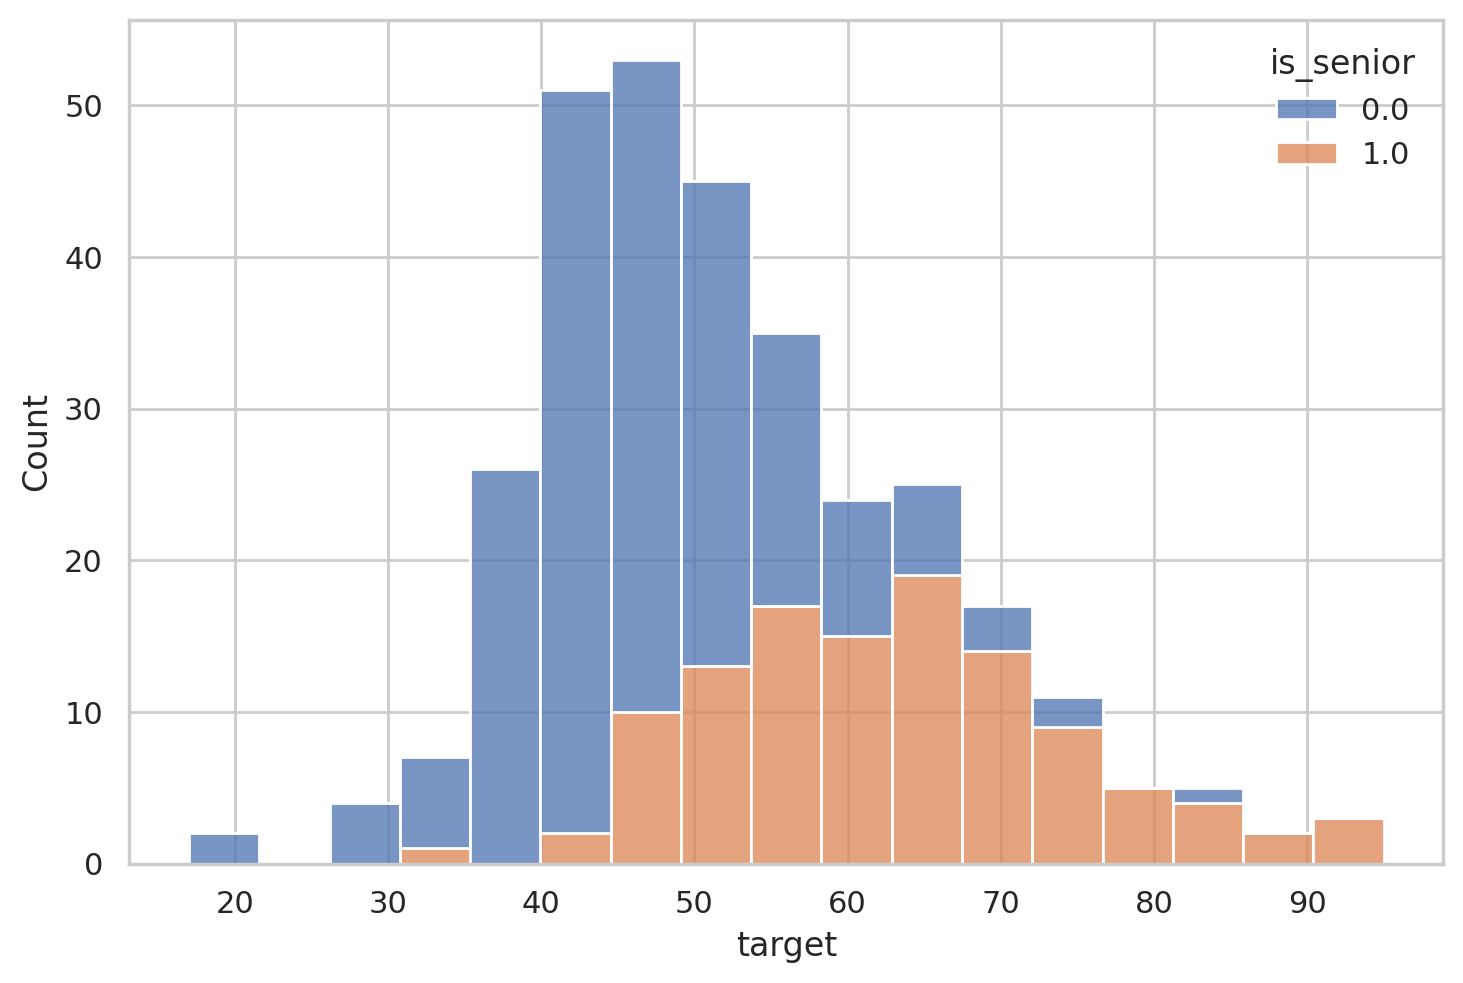

In [7]:
sns.histplot(
    data=df,
    x="target",
    hue="is_senior",
    multiple="stack"
)

In [ ]:
(
    so.Plot(
        data=df.assign(is_senior=lambda df: df.is_senior==1),
        y="salary",
        x="sqrt_yoe",
        color="is_senior"
    )
    .add(so.Dot(pointsize=3), so.Jitter(x=.1))
)

In [ ]:
(
    so.Plot(data=df, y="sector", x="target")
    .add(so.Dot(pointsize=3), so.Jitter(y=.5))
    .layout(size=(10,5))
)

In [ ]:
(
    so.Plot(data=df, y="job_title_no_senior", x="target")
    .add(so.Dot(pointsize=3), so.Jitter(y=.5))
    .layout(size=(10,5))
)

In [ ]:
(
    so.Plot(data=df, x="num_subordinates", y="target")
    .add(so.Dot(pointsize=3), so.Jitter(x=.5))
)

In [ ]:
(
    so.Plot(data=df, x="has_phd", y="target")
    .add(so.Dot(pointsize=3), so.Jitter(x=.1))
)

In [ ]:
(
    so.Plot(data=df, x="small_company", y="target")
    .add(so.Dot(pointsize=3), so.Jitter(x=.1))
)

In [ ]:
(
    so.Plot(data=df, x="received_equity", y="target")
    .add(so.Dot(pointsize=3), so.Jitter(x=.5))
)

In [15]:
# df["is_strange"] = 0
# df.loc[df.salary<=35_000, "is_strange"] = -1
# df.loc[df.salary<=35_000, "is_strange"] = -1
# df.loc[df.salary>=80_000, "is_strange"] = +1

# with pd.option_context('display.max_rows', 5):
#     display((df.sort_values("salary")))
#     # (df.has_subordinates==1) & (df.sqrt_yoe==0)
#     # display(df_raw.drop(columns=["timestamp", "region", "educational_background", "gender", "danish_national", "tool_usage"]).sort_values("salary"))

# PYMC Modelling

In [16]:
id_sector, mn_sectors = df.sector.factorize()

In [17]:
coords_mutable = {
    # dim 1: len of df
    'obs_id': np.arange(len(df)),
    }
coords = {
    "sector": mn_sectors
}


## Model definition and fitting

In [18]:
with pm.Model(coords=coords, coords_mutable=coords_mutable) as model:

    sector = pm.Data("sector", id_sector, mutable=True, dims="obs_id")
    mu_sector = pm.Normal("mu_sector", mu=40.0, sigma=5.0)
    sigma_sector = pm.Exponential("sigma_sector", 1.0)
    z_intercept = pm.Normal("z_intercept", mu=0, sigma=1, dims="sector")
    intercept = pm.Deterministic("intercept", mu_sector + z_intercept * sigma_sector, dims="sector")

    is_senior = pm.Data("is_senior", df.is_senior, mutable=True, dims="obs_id")
    coeff_is_senior = pm.HalfNormal("coeff_is_senior", sigma=10.0)

    sqrt_yoe = pm.Data("sqrt_yoe", df.sqrt_yoe, mutable=True, dims="obs_id")
    coeff_sqrt_yoe = pm.HalfNormal("coeff_sqrt_yoe", sigma=10.0)

    # is_hovedstaden = pm.Data("is_hovedstaden", df.is_hovedstaden, mutable=True, dims="obs_id")
    # coeff_is_hovedstaden = pm.Normal("coeff_is_hovedstaden", mu=0.0, sigma=10.0)

    has_subordinates = pm.Data("has_subordinates", df.has_subordinates, mutable=True, dims="obs_id")
    coeff_has_subordinates = pm.Normal("coeff_has_subordinates", mu=0.0, sigma=10.0)

    # has_phd = pm.Data("has_phd", df.has_subordinates, mutable=True, dims="obs_id")
    # coeff_has_phd = pm.Normal("coeff_has_phd", mu=0.0, sigma=10.0)

    # small_company = pm.Data("small_company", df.has_subordinates, mutable=True, dims="obs_id")
    # coeff_small_company = pm.Normal("coeff_small_company", mu=0.0, sigma=10.0)

    # is_strange = pm.Data("is_strange", df.is_strange, mutable=True, dims="obs_id")
    # coeff_is_strange = pm.Normal("coeff_is_strange", mu=0.0, sigma=10.0)
    

    mu = (
        intercept[sector]
        + coeff_is_senior * is_senior
        + coeff_sqrt_yoe * sqrt_yoe
        # + coeff_is_hovedstaden * is_hovedstaden
        + coeff_has_subordinates * has_subordinates
        # + coeff_has_phd * has_phd
        # + coeff_small_company * small_company
        # + coeff_is_strange * is_strange
    )
    sigma = pm.Exponential("sigma", 1.0)
    # tau = 2.5
    # tau = pm.Exponential("tau", 5.0)
    # alpha = pm.Normal("alpha", mu=0, sigma=1.)

    pm.Normal("obs", mu=mu, sigma=sigma, observed=df.target, dims="obs_id")
    # pm.Gamma("obs", mu=mu, sigma=sigma, observed=df.target, dims="obs_id")
    # pm.SkewNormal("obs", mu=mu, sigma=sigma, alpha=alpha, observed=df.target, dims="obs_id")
    # pm.StudentT("obs", mu=mu, sigma=sigma, nu=tau, observed=df.target, dims="obs_id")

    idata = pm.sample_prior_predictive(samples=1_000, random_seed=rng)
    idata.extend(pm.sample(1_000, tune=2_000, chains=4, random_seed=rng))
    idata.extend(pm.sample_posterior_predictive(trace=idata, random_seed=rng))


Sampling: [coeff_has_subordinates, coeff_is_senior, coeff_sqrt_yoe, mu_sector, obs, sigma, sigma_sector, z_intercept]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_sector, sigma_sector, z_intercept, coeff_is_senior, coeff_sqrt_yoe, coeff_has_subordinates, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 19 seconds.
Sampling: [obs]


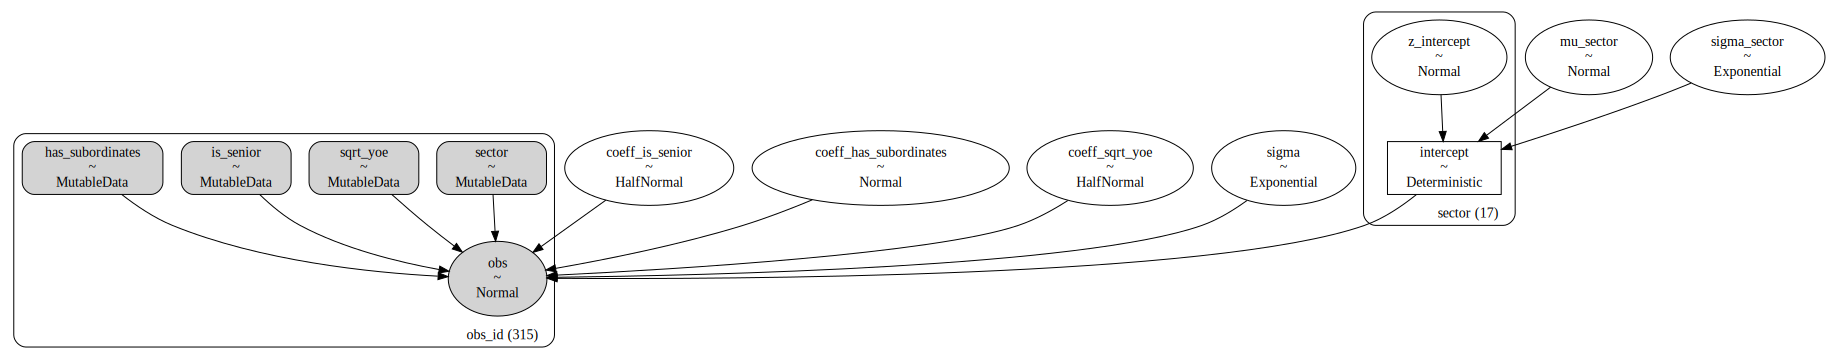

In [19]:
pm.model_to_graphviz(model)

## Model analysis

First, we might look at our prior predictive capacity so that we may judge the our parameter’s ability to predict $y$:

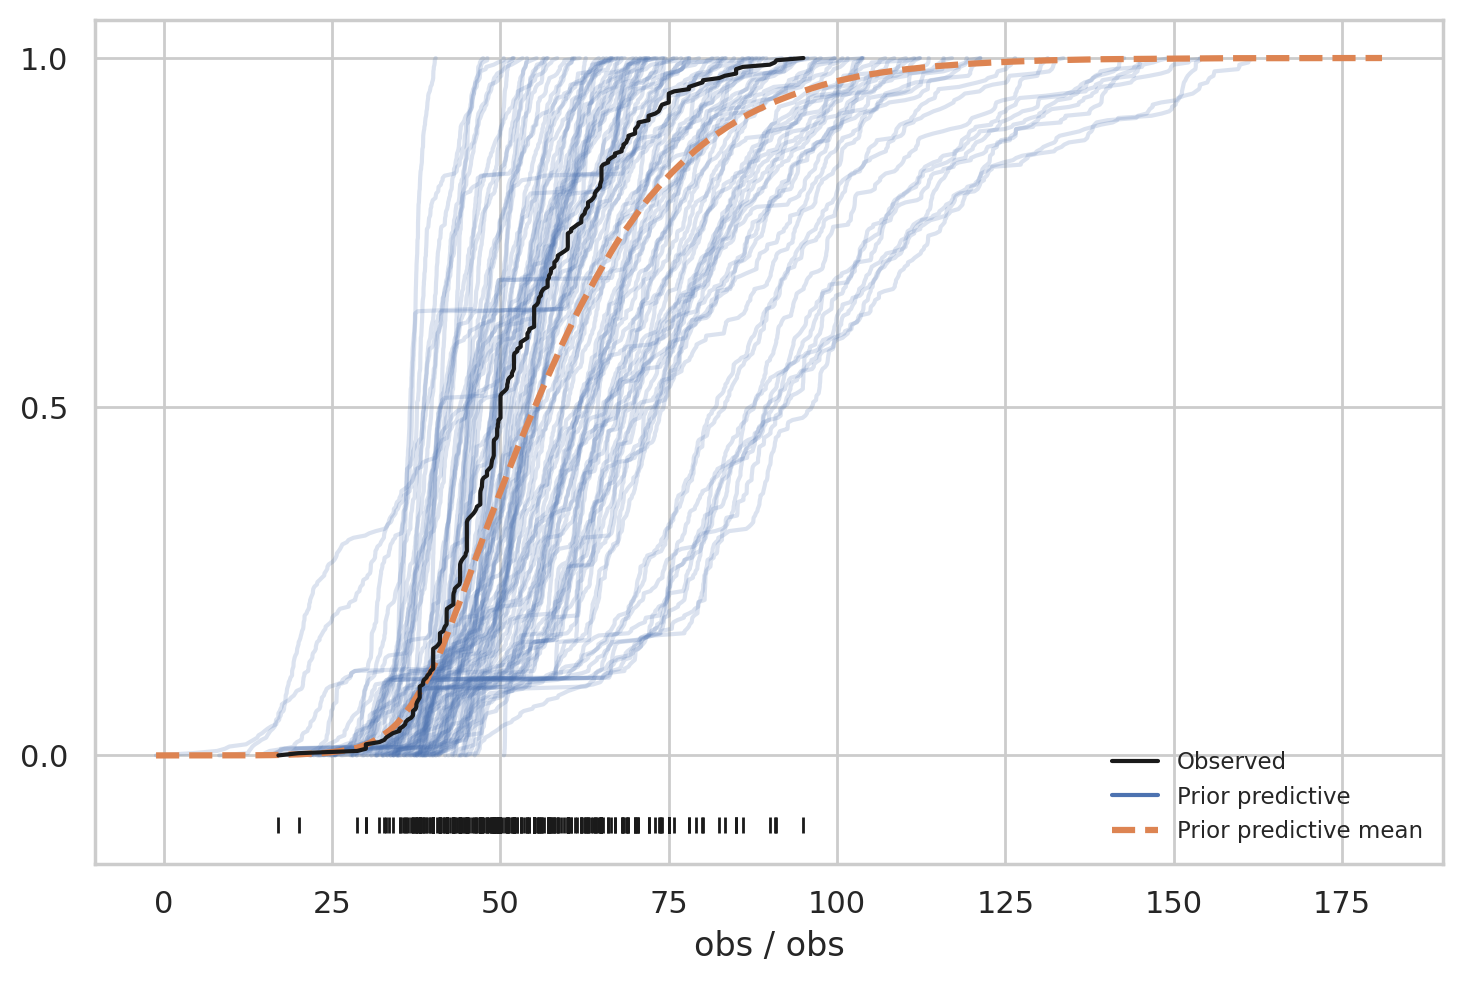

In [20]:
az.plot_ppc(
    data=idata,
    num_pp_samples=100,
    observed=True,
    observed_rug=True,
    kind="cumulative",
    group='prior'
);

The plot below shows the extent to which our model, after learning from the data, is able to retrodict what was observed $y$

array([<AxesSubplot:xlabel='obs / obs'>], dtype=object)

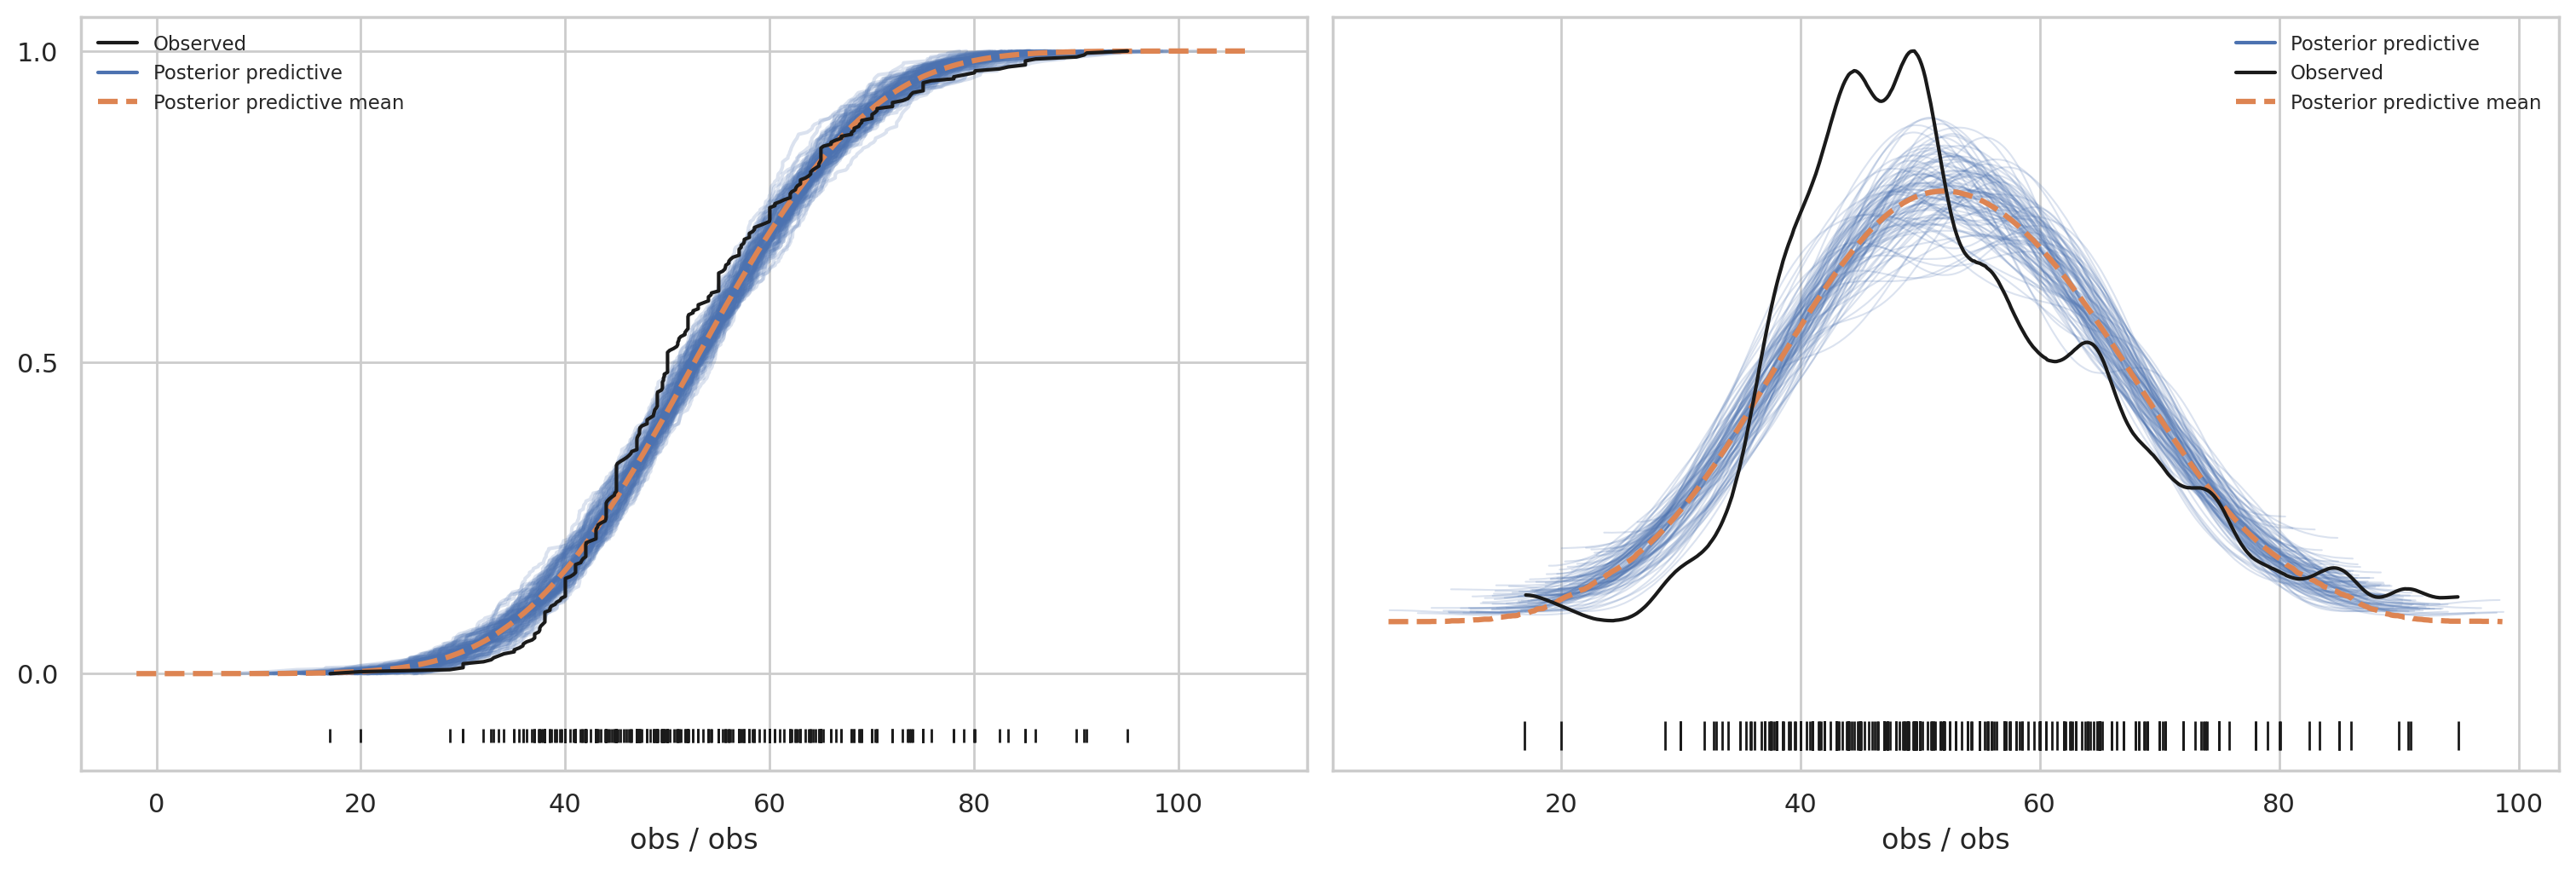

In [21]:
fig, axs = plt.subplots(figsize=(15,5), ncols=2)

az.plot_ppc(
    data=idata,
    num_pp_samples=100,
    observed=True,
    observed_rug=True,
    kind="cumulative",
    ax=axs[0]
)


az.plot_ppc(
    data=idata,
    num_pp_samples=100,
    observed=True,
    observed_rug=True,
    kind="kde",
    ax=axs[1]
)

# axs[0].set(
#     xlim=(0,100)
# )
# axs[1].set(
#     xlim=(0,100)
# )

## Estimated regression coefficients

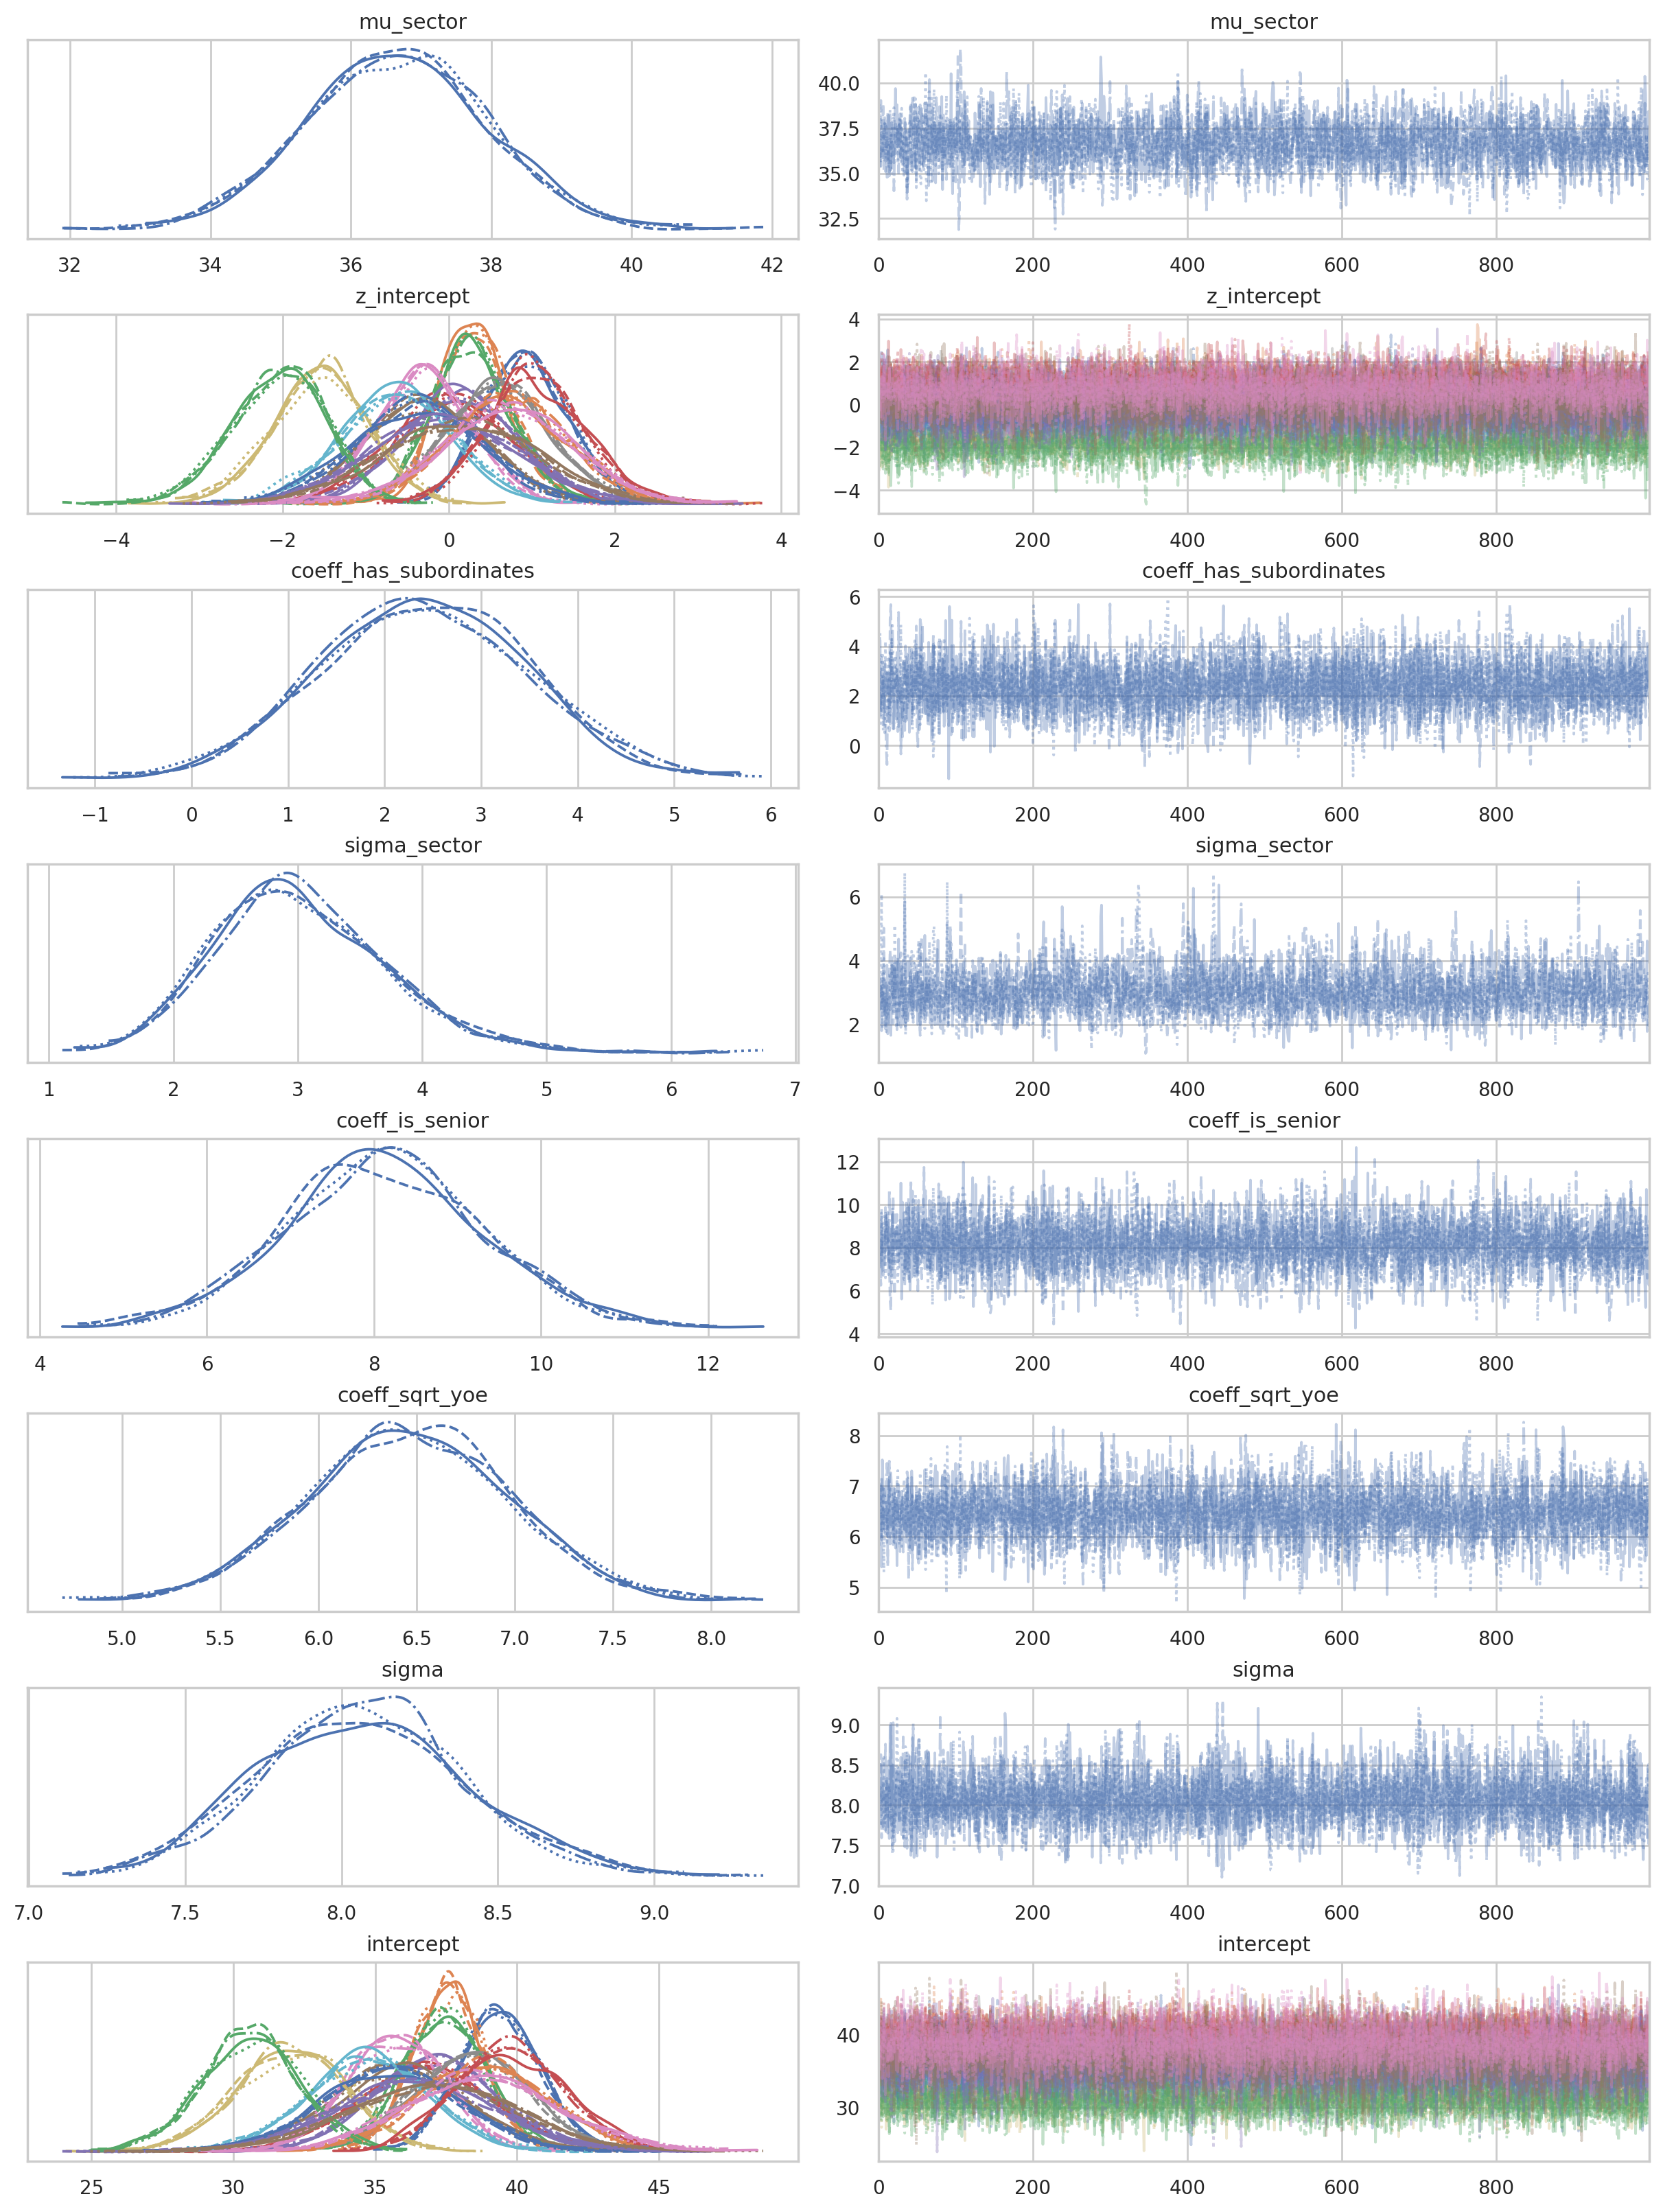

In [22]:
az.plot_trace(idata);

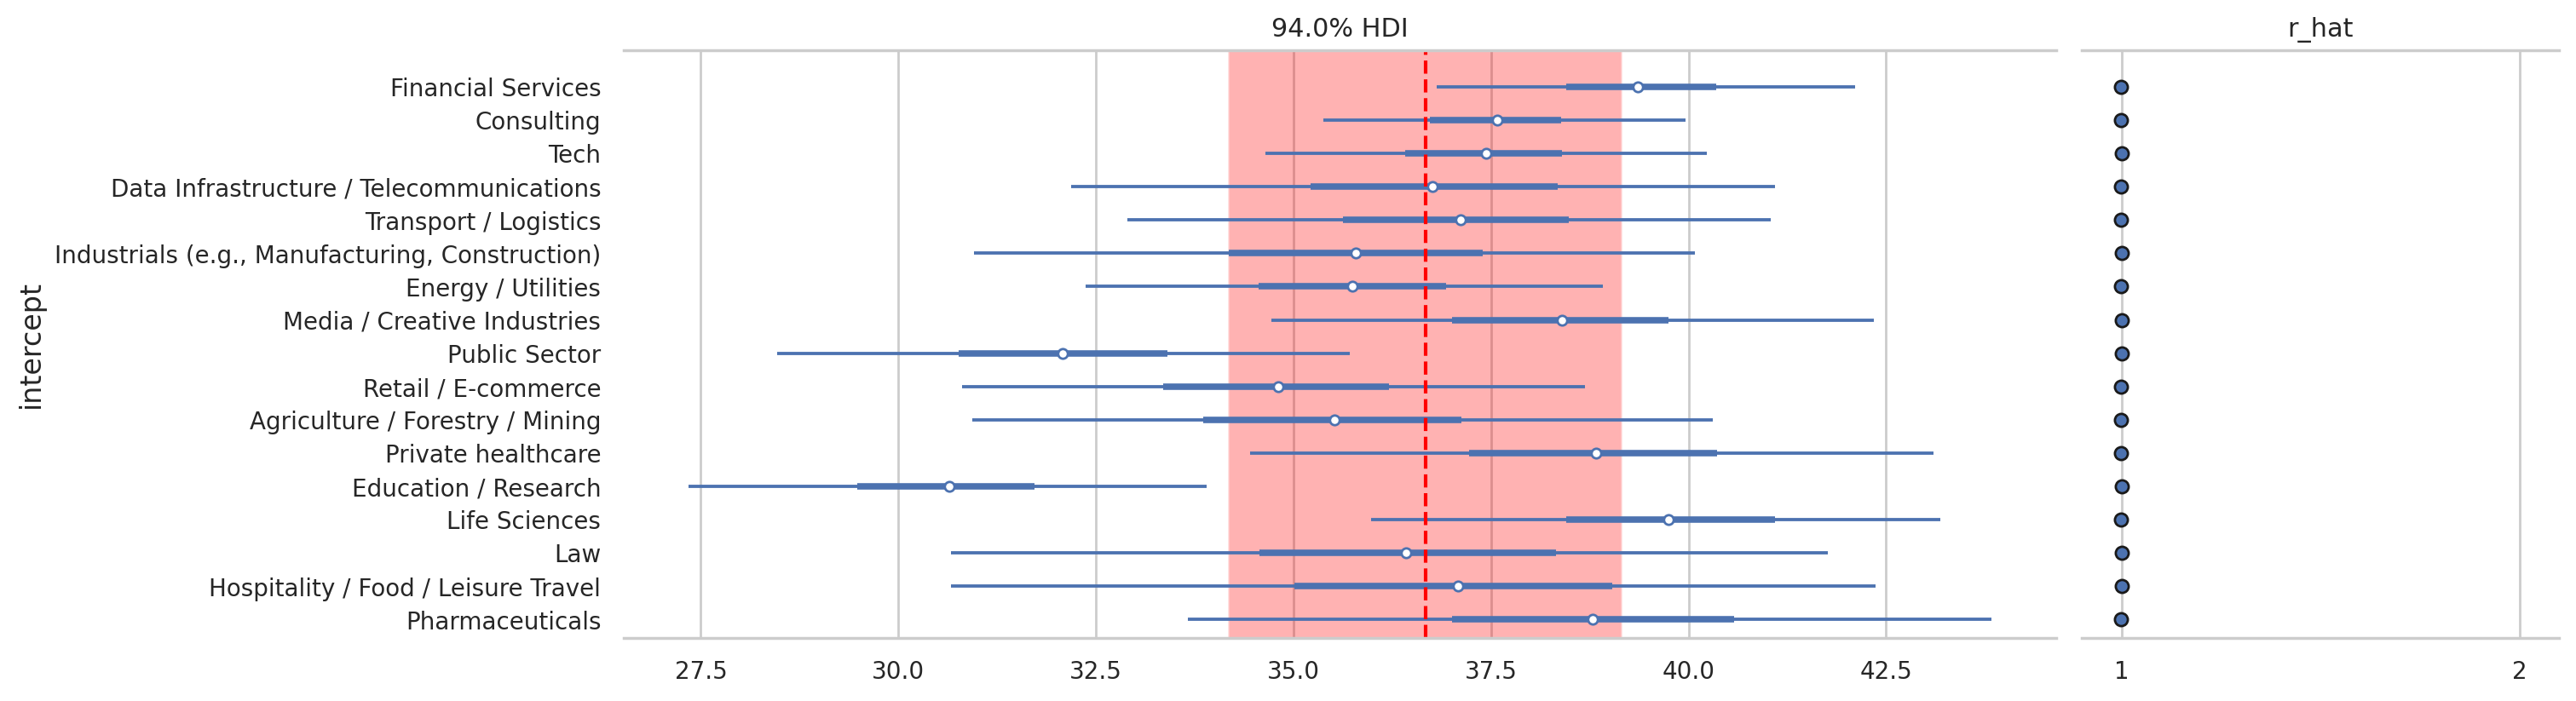

In [23]:
ax = pm.plot_forest(
    idata,
    var_names=["intercept"],
    figsize=(15, 4),
    combined=True,
    r_hat=True,
    labeller=az.labels.NoVarLabeller(),
    textsize=10,
)
ax[0].set_ylabel("intercept")
ax[0].axvline(x=idata.posterior.mu_sector.median(), color="red", ls="--")
ax[0].axvspan(
    idata.posterior.mu_sector.quantile(0.025),
    idata.posterior.mu_sector.quantile(0.975),
    facecolor="red", edgecolor=None, alpha=.3)

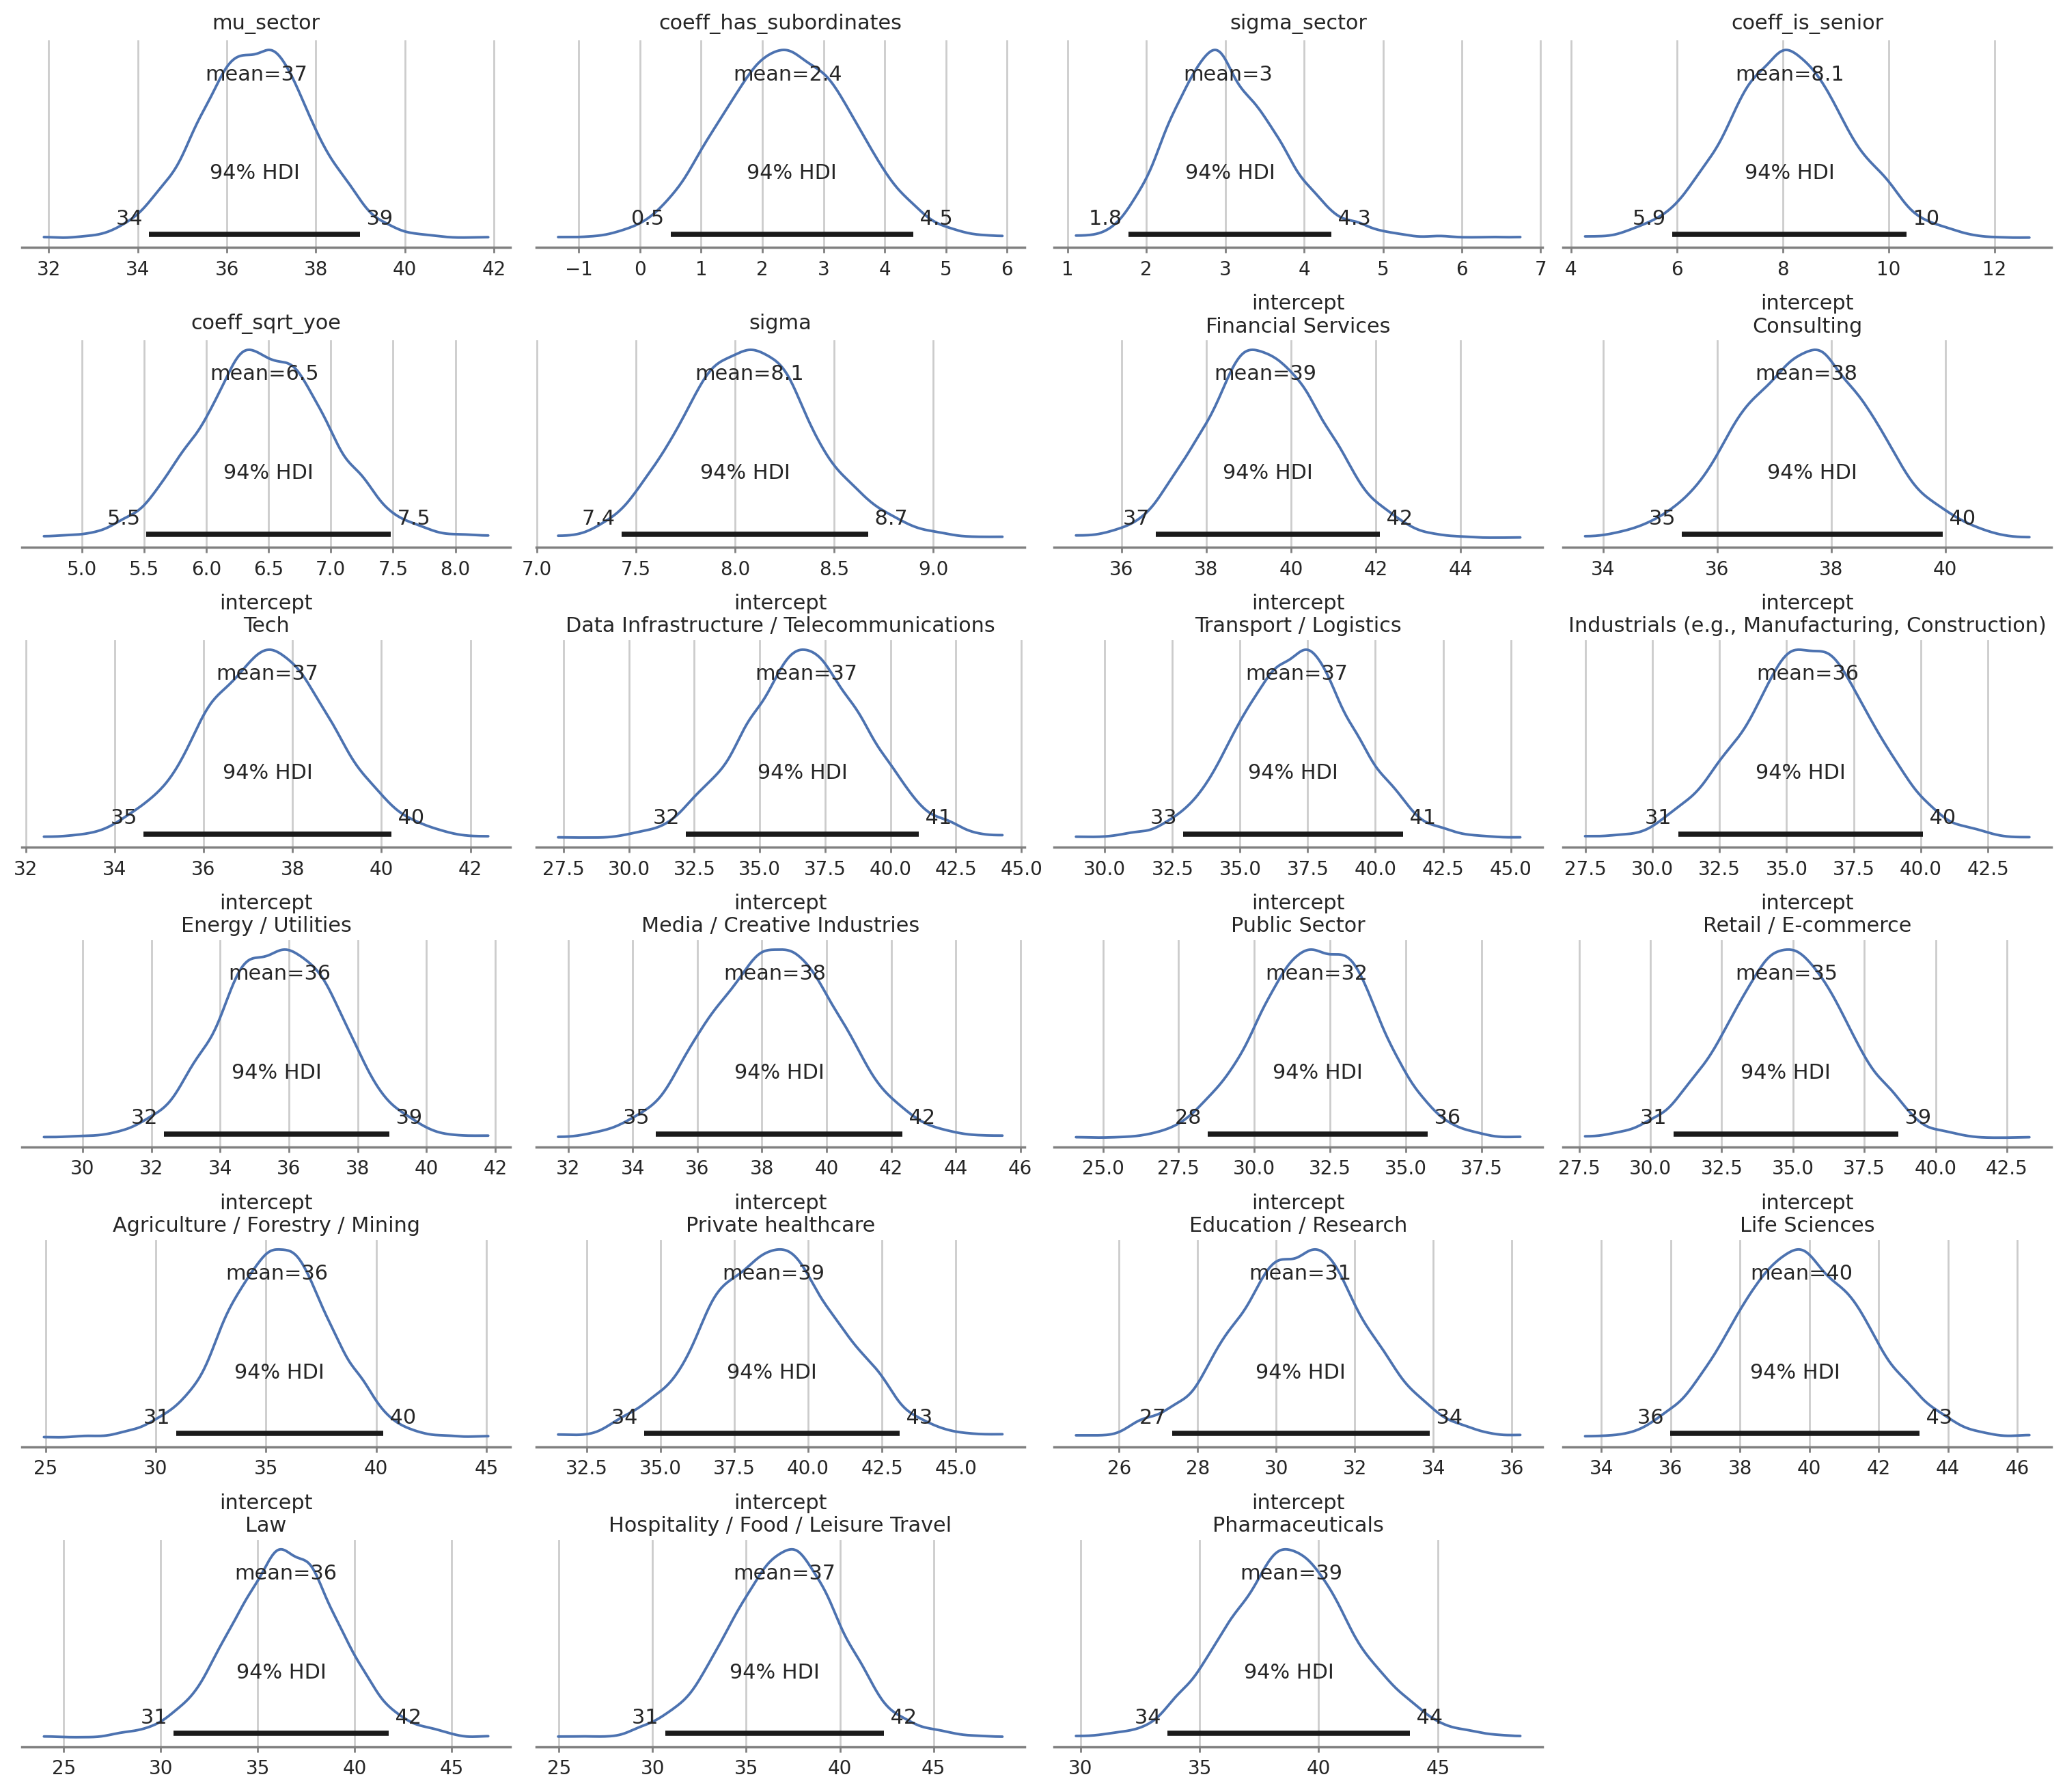

In [24]:
az.plot_posterior(
    idata,
    var_names=["~z_*"],
    filter_vars="regex",
    textsize=10,
    figsize=(15,13)
    );

In [25]:
az.summary(
    idata,
    var_names=["~z_*"],
    filter_vars="regex"
).sort_index()

mean     sd  hdi_3%  \
coeff_has_subordinates                               2.407  1.068   0.499   
coeff_is_senior                                      8.128  1.179   5.914   
coeff_sqrt_yoe                                       6.466  0.522   5.520   
intercept[Agriculture / Forestry / Mining]          35.501  2.490  30.933   
intercept[Consulting]                               37.559  1.206  35.382   
intercept[Data Infrastructure / Telecommunicati...  36.777  2.371  32.188   
intercept[Education / Research]                     30.607  1.726  27.346   
intercept[Energy / Utilities]                       35.726  1.755  32.367   
intercept[Financial Services]                       39.399  1.416  36.814   
intercept[Hospitality / Food / Leisure Travel]      37.031  3.072  30.668   
intercept[Industrials (e.g., Manufacturing, Con...  35.771  2.410  30.954   
intercept[Law]                                      36.442  2.916  30.669   
intercept[Life Sciences]                            39.774  1.912  35.980   
intercept[Media / Creative Industries]              38.395  2.032  34.720   
intercept[Pharmaceuticals]                          38.842  2.729  33.660   
intercept[Private healthcare]                       38.825  2.319  34.454   
intercept[Public Sector]                            32.056  1.937  28.462   
intercept[Retail / E-commerce]                      34.770  2.118  30.807   
intercept[Tech]                                     37.431  1.477  34.647   
intercept[Transport / Logistics]                    37.078  2.177  32.893   
mu_sector                                           36.661  1.282  34.249   
sigma                                                8.071  0.331   7.427   
sigma_sector                                         3.034  0.714   1.771   

                                                    hdi_97%  mcse_mean  \
coeff_has_subordinates                                4.467      0.014   
coeff_is_senior                                      10.340      0.018   
coeff_sqrt_yoe                                        7.481      0.007   
intercept[Agriculture / Forestry / Mining]           40.308      0.033   
intercept[Consulting]                                39.962      0.015   
intercept[Data Infrastructure / Telecommunicati...   41.091      0.030   
intercept[Education / Research]                      33.905      0.027   
intercept[Energy / Utilities]                        38.920      0.021   
intercept[Financial Services]                        42.108      0.018   
intercept[Hospitality / Food / Leisure Travel]       42.363      0.040   
intercept[Industrials (e.g., Manufacturing, Con...   40.079      0.029   
intercept[Law]                                       41.762      0.040   
intercept[Life Sciences]                             43.183      0.024   
intercept[Media / Creative Industries]               42.343      0.024   
intercept[Pharmaceuticals]                           43.827      0.037   
intercept[Private healthcare]                        43.104      0.028   
intercept[Public Sector]                             35.715      0.028   
intercept[Retail / E-commerce]                       38.691      0.028   
intercept[Tech]                                      40.229      0.019   
intercept[Transport / Logistics]                     41.034      0.027   
mu_sector                                            38.992      0.022   
sigma                                                 8.672      0.004   
sigma_sector                                          4.349      0.015   

                                                    mcse_sd  ess_bulk  \
coeff_has_subordinates                                0.011    6054.0   
coeff_is_senior                                       0.012    4468.0   
coeff_sqrt_yoe                                        0.005    4837.0   
intercept[Agriculture / Forestry / Mining]            0.024    5638.0   
intercept[Consulting]                                 0.011    

In [26]:
# ax = az.plot_forest(
#     idata,
#     # var_names=["alpha"],
#     r_hat=True,
#     combined=True,
#     figsize=(10, 5),
#     # labeller=az.labels.NoVarLabeller(),
# )
# # ax[0].set_ylabel("alpha");

## Model predictions

In [27]:
# with model:
#     # set it over the feature data
#     pm.set_data(
#         new_data=dict(
#             is_senior=np.arange(0,15)*0,
#             years_experience=np.arange(0,15),
#         ),
#         coords=dict(
#             obs_id=np.arange(0,15)
#         ))
#     # generate preds
#     predictions = pm.sample_posterior_predictive(idata, predictions=True)

In [28]:
# in-sample
with model:
    predictions = pm.sample_posterior_predictive(idata, predictions=True)

Sampling: [obs]


In [ ]:
pred_df = (
    pd.DataFrame(dict(
        real=df.target,
        pred=predictions.predictions['obs'].median(dim=('chain', 'draw')).values,
        q025=predictions.predictions["obs"].quantile(0.025, dim=("chain", "draw")).values,
        q25=predictions.predictions["obs"].quantile(0.25, dim=("chain", "draw")).values,
        q75=predictions.predictions["obs"].quantile(0.75, dim=("chain", "draw")).values,
        q975=predictions.predictions["obs"].quantile(0.975, dim=("chain", "draw")).values,
    ))
    .assign(
        error=lambda df: df.pred-df.real,
        iqr=lambda df: df.q75-df.q25,
        is_in_50=lambda df: (df.real>=df.q25) & (df.real<=df.q75),
        is_in_95=lambda df: (df.real>=df.q025) & (df.real<=df.q975),
    )
)

display(pred_df.head())

display(pred_df[["iqr", "is_in_50", "is_in_95"]].mean())

print(f"MAE: {pred_df.error.abs().mean()}")
print(f"RMSE: {(pred_df.error**2).mean()**0.5}")

[Text(0.5, 0, 'real'), Text(0, 0.5, 'pred')]

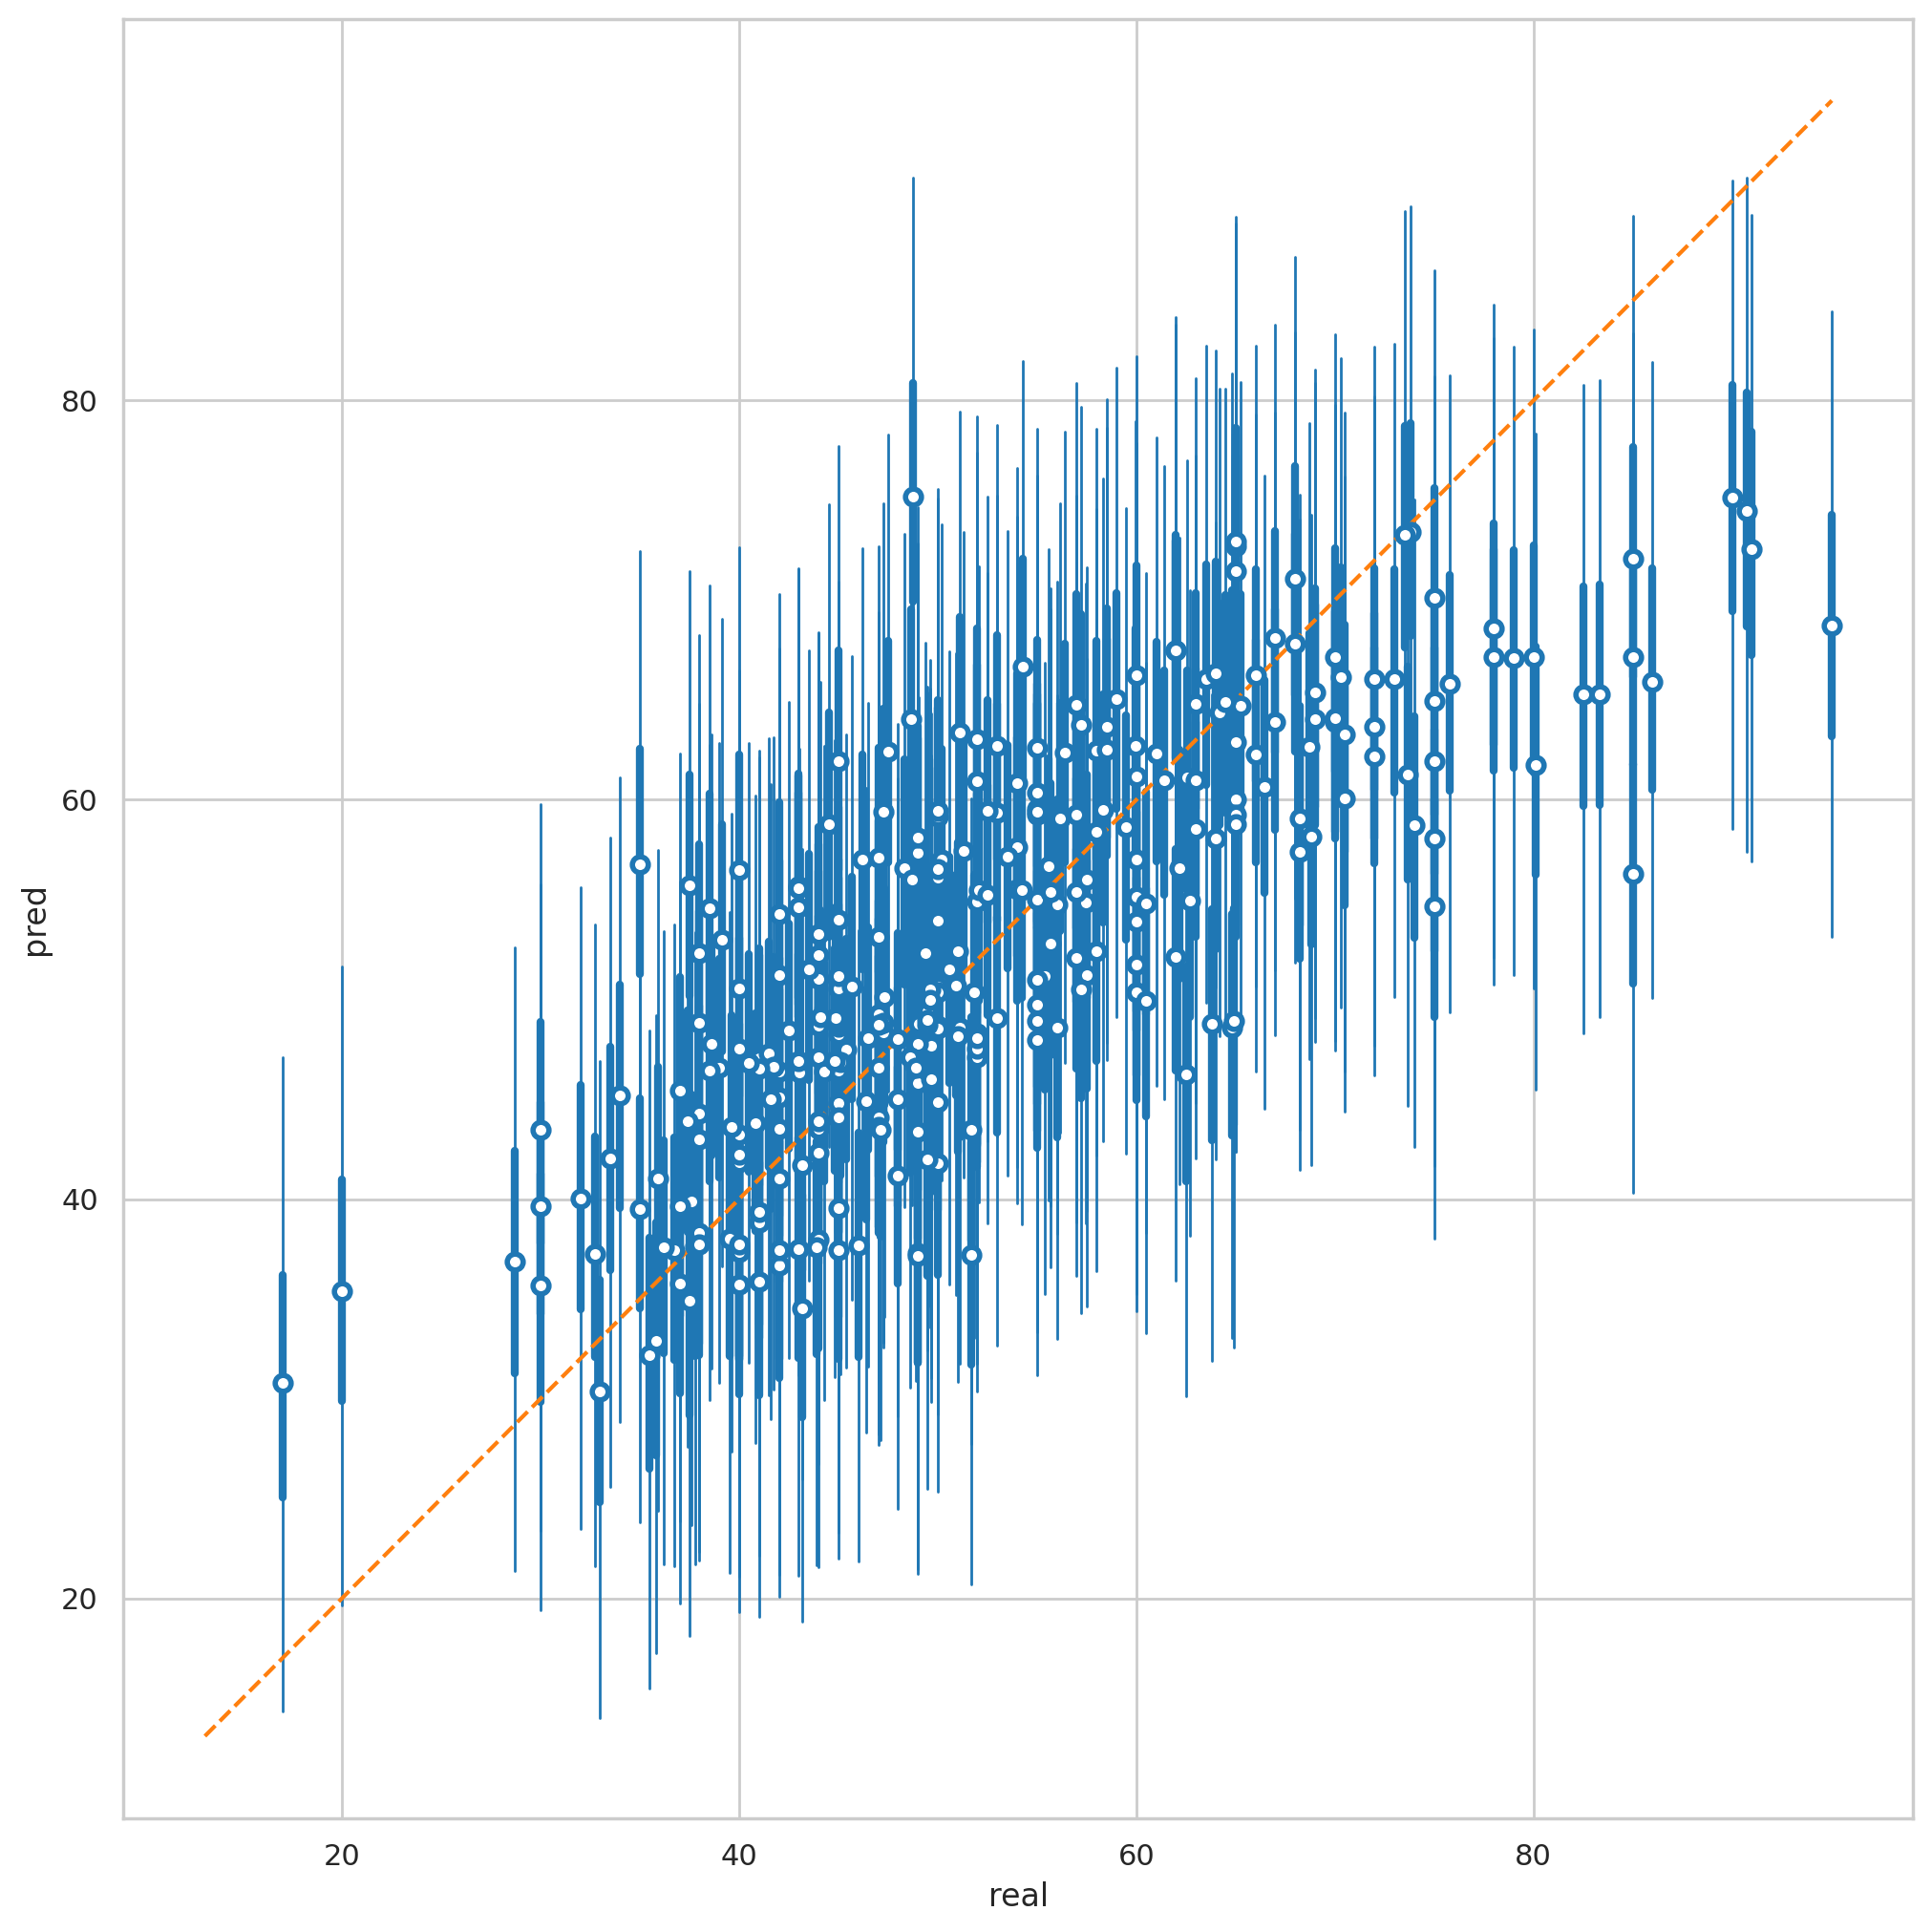

In [30]:
fig, ax = plt.subplots(figsize=(10,10))

for _, row in pred_df.iterrows():
    ax.plot((row.real, row.real), (row.q025, row.q975), lw=1, color="tab:blue")
    ax.plot((row.real, row.real), (row.q25, row.q75), lw=3, color="tab:blue")
    ax.scatter(row.real, row.pred, color="white", edgecolors="tab:blue", linewidths=2, zorder=10)

axmin = max(ax.get_xlim()[0], ax.get_ylim()[0])
axmax = min(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot((axmin, axmax), (axmin, axmax), color="tab:orange", ls="--")
ax.set(
    xlabel="real",
    ylabel="pred"
)

In [ ]:
ax = (
    pd.DataFrame(dict(
        real=df.target,
        pred=predictions.predictions['obs'].median(dim=('chain', 'draw')).values
    ))
    .plot.scatter(
        x="real",
        y="pred",
        s=3
    )
)

axmin = max(ax.get_xlim()[0], ax.get_ylim()[0])
axmax = min(ax.get_xlim()[1], ax.get_ylim()[1])
ax.plot((axmin, axmax), (axmin, axmax), color="tab:orange", ls="--")

In [ ]:
pred_df[
    (pred_df.real>=40) & (pred_df.real<=45)
    & (pred_df.pred>=pred_df.real+5)
].head()

In [34]:
fig = px.scatter(
    pd.concat([pred_df, df], axis=1),
    x="real",
    y="pred",
    color="sector",
    hover_data=df.columns.to_list(),
    width=1_000,
    height=700,
    )
fig.add_scatter(x=[20,90], y=[20,90], mode='lines')

fig.show()